In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from prophet import Prophet

import boto3
import awswrangler as wr

import os
from dotenv import load_dotenv
from datetime import datetime

/Users/ernestsalim/Devs/Personal/stock-analysis/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [6]:
load_dotenv()

AWS_ACCESS_KEY = os.environ.get("AWS_ACCESS_KEY_ID")
AWS_SECRET_KEY = os.environ.get("AWS_SECRET_ACCESS_KEY")

In [17]:
glue_db = "alpaca_stocks_database"
glue_monthly_table = f"stocks_table_{datetime.now().year}_{datetime.now().month}"
glue_historical_table = "stocks_table_historical"

In [18]:
boto3.setup_default_session(
    aws_access_key_id = AWS_ACCESS_KEY,
    aws_secret_access_key = AWS_SECRET_KEY,
    region_name = "us-west-1")

In [72]:
athena_query = f'''
    SELECT *
    FROM {glue_historical_table}
    WHERE symbol = 'AIG'
    ORDER BY timestamp ASC
'''

dataset = wr.athena.read_sql_query(athena_query, database = glue_db, ctas_approach = True)

## Prophet Approach

In [73]:
dataset_train, dataset_test = dataset.iloc[0:1920], dataset.iloc[1920:]

In [74]:
x = dataset_train[['timestamp', 'open']].rename(columns={'timestamp': 'ds', 'open': 'y'})
x['ds'] = x['ds'].dt.strftime('%Y-%m-%d')

y = dataset_test[['timestamp', 'open']].rename(columns={'timestamp': 'ds', 'open': 'y'})
y['ds'] = y['ds'].dt.strftime('%Y-%m-%d')

In [75]:
x

,ds,y
0,2016-01-04,60.66
1,2016-01-05,60.45
2,2016-01-06,59.87
3,2016-01-07,58.53
4,2016-01-08,58.81
...,...,...
1915,2023-08-14,60.33
1916,2023-08-15,59.15
1917,2023-08-16,58.78
1918,2023-08-17,58.87


In [76]:
m = Prophet()
m.add_country_holidays(country_name='US')
m.fit(x)

17:55:42 - cmdstanpy - INFO - Chain [1] start processing
17:55:43 - cmdstanpy - INFO - Chain [1] done processing


In [77]:
future = m.make_future_dataframe(periods=32)

In [78]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1947,2023-09-15,55.916453,51.762882,60.148162
1948,2023-09-16,60.445005,55.963597,64.878311
1949,2023-09-17,60.440442,56.216472,64.831878
1950,2023-09-18,55.878157,51.231985,60.013747
1951,2023-09-19,55.993689,51.969324,60.004884


In [79]:
y.tail()

,ds,y
1936,2023-09-13,60.71
1937,2023-09-14,61.00
1938,2023-09-15,60.75
1939,2023-09-18,61.28
1940,2023-09-19,62.03


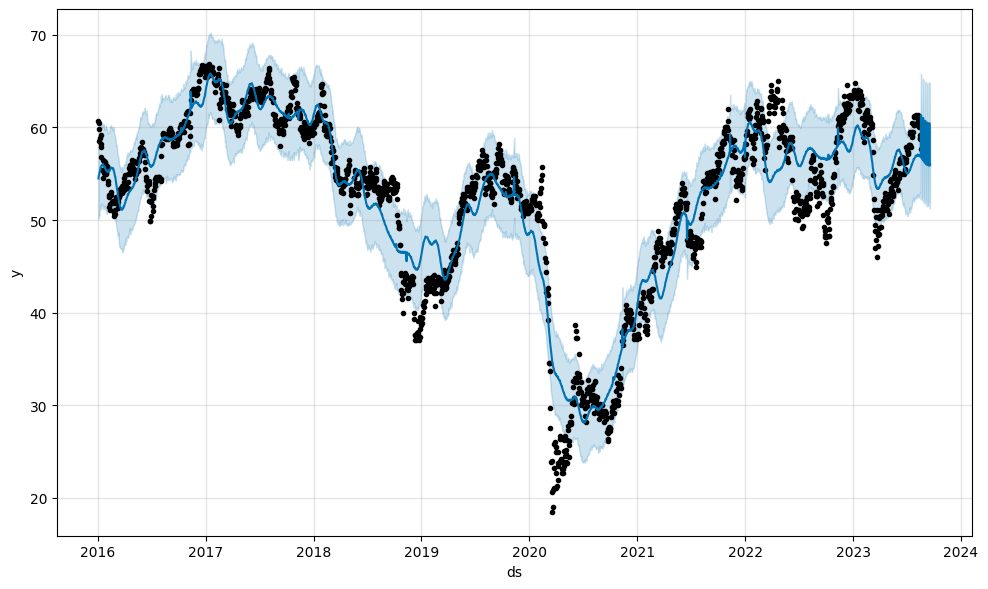

In [81]:
plot1 = m.plot(forecast)

## LSTM Approach

In [86]:
dataset_train, dataset_test = dataset.iloc[0:1920], dataset.iloc[1920:]

training_set = dataset_train.iloc[:, 3:4].values

In [73]:
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [77]:
training_set_scaled.shape[0]

1920

In [78]:
X_train = []
y_train = []

for i in range(60, training_set_scaled.shape[0]):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [80]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
59/59 [==============================] - 6s 44ms/step - loss: 0.0181
Epoch 2/100
59/59 [==============================] - 3s 45ms/step - loss: 0.0095
Epoch 3/100
59/59 [==============================] - 3s 48ms/step - loss: 0.0059
Epoch 4/100
59/59 [==============================] - 3s 47ms/step - loss: 0.0057
Epoch 5/100
59/59 [==============================] - 3s 47ms/step - loss: 0.0054
Epoch 6/100
59/59 [==============================] - 3s 47ms/step - loss: 0.0047
Epoch 7/100
59/59 [==============================] - 3s 47ms/step - loss: 0.0045
Epoch 8/100
59/59 [==============================] - 4s 60ms/step - loss: 0.0042
Epoch 9/100
59/59 [==============================] - 3s 49ms/step - loss: 0.0040
Epoch 10/100
59/59 [==============================] - 3s 49ms/step - loss: 0.0043
Epoch 11/100
59/59 [==============================] - 3s 53ms/step - loss: 0.0038
Epoch 12/100
59/59 [==============================] - 4s 63ms/step - loss: 0.0042
Epoch 13/100
59/59 [=====